# 7 Combining Analysis - Generating Final DataFrame

After exploring the individual components required for Forex prediction, all of the covered components could be brought together to build a prediction architecture and evaluate this holistic method for Forex  trend prediction. This notebook pulls together the pre-processing and feature generation techniques of earlier notebooks to produce a final DataFrame to be forecasted by machine learning models.

In [438]:
#Library imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy

from sklearn.preprocessing import StandardScaler

import math
#Import for data visualisation
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


#Technical Indicator Libraries
import talib as ta
import pandas_ta as new_ta

import seaborn as sns

from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from bs4 import BeautifulSoup
import requests
from urllib.request import Request, urlopen

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import snscrape.modules.twitter as sntwitter

import os

import re, string

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import praw
from pushshift_py import PushshiftAPI 

import math
import json
import itertools
import requests
import time
from datetime import datetime, timedelta, timezone

## 7.1 Data Acquisition & EDA

In [674]:
#Function to acquire and clean data
def get_OHLC_data():

    #Get dataset from Dukaskopy
    data = pd.read_csv("./Data/AUDUSD_Candlestick_1_D_ASK_01.01.2011-01.01.2019.csv")

    data['Date'] = pd.to_datetime(data.Date, format="%d.%m.%Y %H:%M:%S.%f")

    data['Date'] = pd.DataFrame(data.Date).applymap(lambda x: x.date())
    
    data = data.set_index(data.Date).drop(columns=['Date'])
    
    #Remove data with volume of 0 as this corresponds to a weekend when no trading occurs
    data = data[data['Volume'] != 0]
    
    #Calculate adjusted close to smooth data
    data['Adj_Close'] = data.Close.ewm(alpha=0.1).mean()
    
    data['HL_Avg'] = ((data.High + data.Low)/2)
    
    data['High_MA'] = data.High.rolling(3).mean()

    data['Low_MA'] = data.Low.rolling(3).mean()
    
    data['HL_Avg_Rolling'] = ((data.High_MA + data.Low_MA)/2)
    
    data['Raw_Return'] = np.log(data.Close) - np.log(data.Close.shift(1))
    
    data['Smoothed_Return'] = np.log(data.HL_Avg_Rolling) - np.log(data.HL_Avg_Rolling.shift(5))
    
    data = data.dropna()
    
    return data

#Plot closing price and smooth closing price
def plot_feature(feature, name):
    
    fig,ax = plt.subplots(figsize=(15,7))
    
    ax.plot(feature.index, feature)
    
    ax.set_title(name)
    ax.set_ylabel(name)
    ax.set_xlabel("Date")

In [675]:
df = get_OHLC_data()
df

Open     High      Low    Close       Volume  Adj_Close  \
Date                                                                     
2011-01-11  0.98728  0.99678  0.98055  0.99657  113429.9389   0.997510   
2011-01-12  0.99661  1.00200  0.99282  0.99769  106874.0247   0.997540   
2011-01-13  0.99772  0.99944  0.98574  0.98903  108668.1252   0.996233   
2011-01-16  0.99101  0.99690  0.98646  0.99379   76020.3881   0.995877   
2011-01-17  0.99383  1.00060  0.98987  0.99934  108866.6377   0.996360   
...             ...      ...      ...      ...          ...        ...   
2018-12-25  0.70428  0.70723  0.70333  0.70693   77848.7096   0.715259   
2018-12-26  0.70693  0.70786  0.70173  0.70352  193196.9914   0.714085   
2018-12-27  0.70338  0.70698  0.70287  0.70412  147956.1087   0.713089   
2018-12-30  0.70450  0.70721  0.70334  0.70534  108426.1493   0.712314   
2019-01-01  0.70542  0.70554  0.69826  0.69853  190119.7498   0.710935   

              HL_Avg   High_MA    Low_MA  HL_Avg_Rolling  Raw_Return  \
Date                                                                   
2011-01-11  0.988665  0.996993  0.983703        0.990348    0.009356   
2011-01-12  0.997410  0.998217  0.985177        0.991697    0.001123   
2011-01-13  0.992590  0.999407  0.986370        0.992888   -0.008718   
2011-01-16  0.991680  0.999447  0.988340        0.993893    0.004801   
2011-01-17  0.995235  0.998980  0.987357        0.993168    0.005569   
...              ...       ...       ...             ...         ...   
2018-12-25  0.705280  0.707087  0.703533        0.705310    0.003841   
2018-12-26  0.704795  0.707383  0.702933        0.705158   -0.004835   
2018-12-27  0.704925  0.707357  0.702643        0.705000    0.000852   
2018-12-30  0.705275  0.707350  0.702647        0.704998    0.001731   
2019-01-01  0.701900  0.706577  0.701490        0.704033   -0.009702   

            Smoothed_Return  
Date                         
2011-01-11        -0.020048  
2011-01-12        -0.011483  
2011-01-13        -0.005300  
2011-01-16        -0.001429  
2011-01-17         0.000682  
...                     ...  
2018-12-25        -0.016345  
2018-12-26        -0.013739  
2018-12-27        -0.008964  
2018-12-30        -0.004642  
2019-01-01        -0.003002  

[2084 rows x 12 columns]

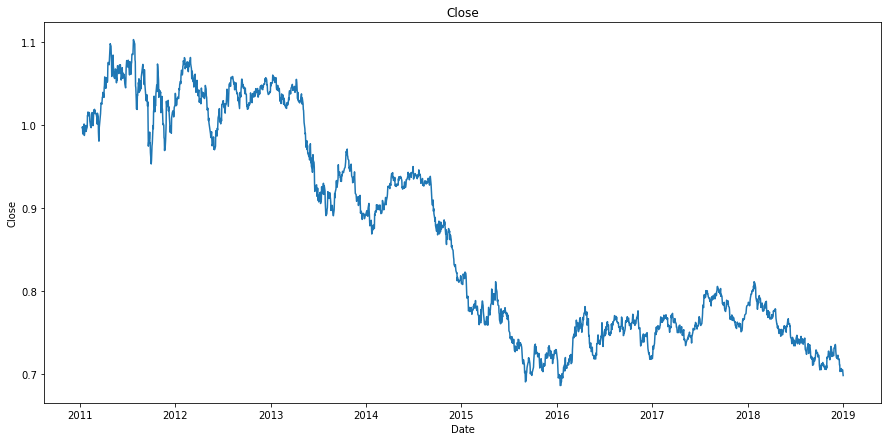

In [676]:
plot_feature(df.Close, 'Close')

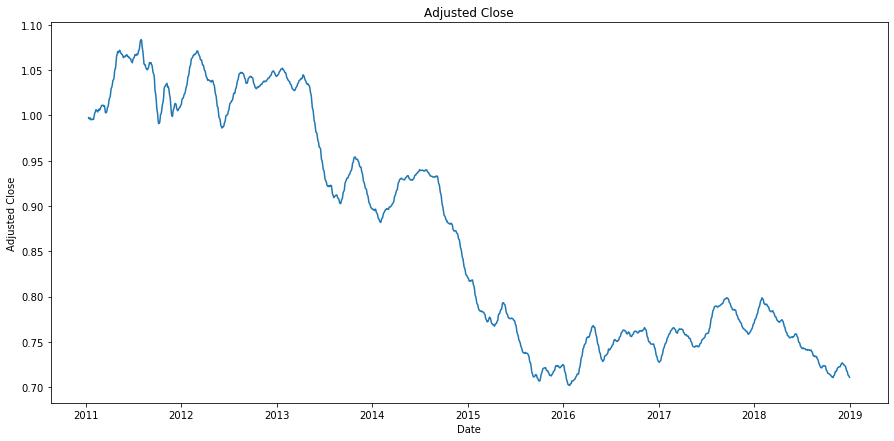

In [677]:
plot_feature(df.Adj_Close, 'Adjusted Close')

It can be seen from the decomposition below that the time series has some type of seasonality, this is important as it stresses that this must be removed, i.e. the data must be made stationary to allow for clear forecasting and analysis of the pure data and see relationships between input and output variables

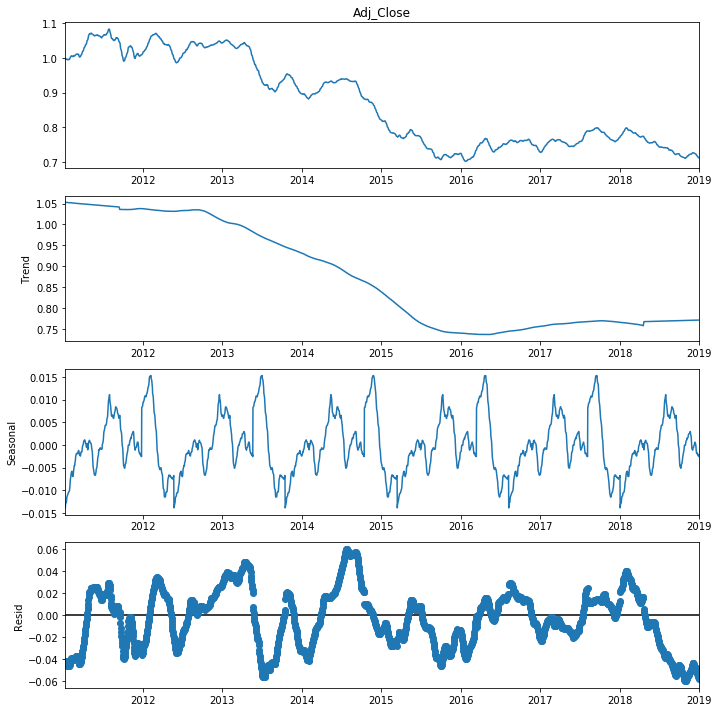

In [678]:
#Seasonal decomposition of data to show underlying trends
data_decomp = seasonal_decompose(df.Adj_Close, model="additive", extrapolate_trend='freq', period=365)

plt.rcParams.update({'figure.figsize': (10,10)})

data_decomp.plot()

plt.show()

In [679]:
#Autocorrelation and Partial-Autocorrelaation Plots
def acf_pcf(close, lags):

    fig, ax = plt.subplots(1,2,figsize=(16,3))

    plot_acf(close.tolist(), lags=lags, ax=ax[0])
    
    plot_pacf(close.tolist(), lags=lags, ax=ax[1])
        
    plt.show()

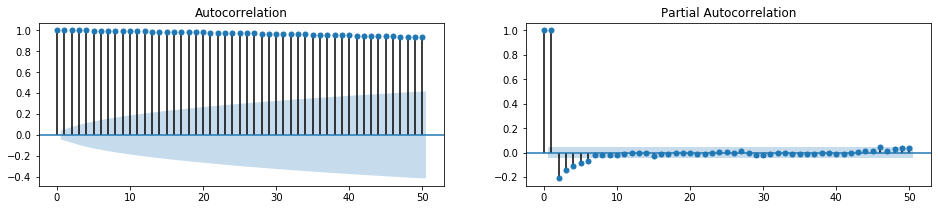

In [680]:
acf_pcf(df.Adj_Close, 50)

## 7.2 Feature Generation - Technical Analysis

Technical indicators are generated through technical analysis for feature engineering.

In [681]:
#SSL Indicator Function
def ssl_channel_indicator(df, period = 20):
    
    df['SMA_High'] = ta.SMA(df.High, timeperiod=period)
    
    df['SMA_Low'] = ta.SMA(df.Low, timeperiod=period)
    
    hlv = pd.DataFrame(columns=['HLV'], index=df.index)
    
    sslDown = pd.DataFrame(columns=['SSL_Down'], index=df.index)
    
    sslUp = pd.DataFrame(columns=['SSL_Up'], index=df.index)
    
    for i in range(0,len(df.Close)):
        
        if df.Close.iloc[i] > df.SMA_High.iloc[i]:
            
            hlv.iloc[i] = 1
            
        elif df.Close.iloc[i] < df.SMA_Low.iloc[i]:
            
            hlv.iloc[i] = -1
            
        else:
            
            hlv.iloc[i] = hlv.iloc[i-1]
            
    for i in range(0,len(hlv)):
        
        if hlv.HLV.iloc[i] <= 0:
            
            sslDown.iloc[i] = df.SMA_High.iloc[i]
            
        else:
            
            sslDown.iloc[i] = df.SMA_Low.iloc[i]
            
    for i in range(0,len(hlv)):
        
        if hlv.HLV.iloc[i] < 0:
            
            sslUp.iloc[i] = df.SMA_Low.iloc[i]
            
        else:
            
            sslUp.iloc[i] = df.SMA_High.iloc[i]     
    
    return sslDown, sslUp

#ATR Indicator Function
def atr_indicator(df, period = 13):
    
    atr = new_ta.atr(df.High, df.Low, df.Close, period)

    return atr

#Linear WMA Indicaotr Function
def lwma_indicator(df, period=15):
        
    lwma = pd.DataFrame(columns=['LWMA'], index=df.index)
    
    for i in range(0,len(df)):
        
        if i < (period-1):
            
            continue
        
        else:
            
            sum_prices = 0
    
            for j in range(0,period+1):
            
                price = df.Close.iloc[i-j]
                
                sum_prices += (price * (period-j))
                
            lwma.iloc[i] = sum_prices/(np.sum(range(1,period+1)))
        
    return lwma

#QQE indicators function - similar to RSI indicator (shows trend strength signal)
def qqe_indicator(df, period=10):
    
    qqe = new_ta.qqe(df.Close, length=period)
    
    qqe.columns = ['QQE','RSI','Long','Short']

    qqe = qqe.reset_index().drop(columns=['Long','Short'])
    
    QQE = qqe['QQE']

    RSI = qqe['RSI']
    
    return QQE.values, RSI.values

#Volatility Index Indicator
def volatility_index_indicator(df, period=10):
    
    volatility = pd.DataFrame(columns=['VOLATILITY'], index=df.index)
    
    for i in reversed(range(0,len(df)-1)):
        
        if df.Close.iloc[i] > df.Open.iloc[i]:
            
            volatility.iloc[i] = abs(df.High.iloc[i] - df.Low.iloc[i+1])
        
        elif df.Close.iloc[i] < df.Open.iloc[i]:
            
            volatility.iloc[i] = abs(df.Low.iloc[i] - df.High.iloc[i+1])
            
        else:
            
            volatility.iloc[i] = volatility.iloc[i+1]
        
    volatility = ta.SMA(volatility.VOLATILITY, timeperiod=5)
    
    sma_vol = ta.SMA(volatility, timeperiod=15)
            
    return volatility, sma_vol

#Function to generate technical analysis features
def technical_analysis(data, period):
    
    #volatility indicators
    df['ATR'] = ta.ATR(df.High, df.Low, df.Close, timeperiod=10)
    
    #momentum indicators
    df['ADX'] = ta.ADX(df.High, df.Low, df.Close, timeperiod=10)
    
    df['AROON_Down'], df['AROON_Up'] = ta.AROON(df.High, df.Low, timeperiod = 10)
    
    df['CCI'] = ta.CCI(df.High, df.Low, df.Close, timeperiod = 10)
    
    df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = ta.MACD(df.Close, fastperiod=15, slowperiod=30)
    
    df['PROC12'] = ta.ROC(df.Close, timeperiod = 12)
    
    df['PROC13'] = ta.ROC(df.Close, timeperiod = 13)
    
    df['PROC14'] = ta.ROC(df.Close, timeperiod = 14)
    
    df['PROC15'] = ta.ROC(df.Close, timeperiod = 15)
    
    df['W%R6'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=6)
    
    df['W%R7'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=7)

    df['W%R8'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=8)

    df['W%R9'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=9)

    df['W%R10'] = ta.WILLR(df.High, df.Low, df.Close, timeperiod=10)

    df['STOCH_K5'], df['STOCH_D5'] = ta.STOCH(df.High, df.Low, df.Close, fastk_period=5)
    
    df['STOCH_K8'], df['STOCH_D8'] = ta.STOCH(df.High, df.Low, df.Close, fastk_period=8)

    df['STOCH_K10'], df['STOCH_D10'] = ta.STOCH(df.High, df.Low, df.Close, fastk_period=10)
    
    df['MOM3'] = ta.MOM(df.Close, timeperiod=3)
    
    df['MOM5'] = ta.MOM(df.Close, timeperiod=5)
    
    df['MOM8'] = ta.MOM(df.Close, timeperiod=8)
    
    df['MOM9'] = ta.MOM(df.Close, timeperiod=9)
    
    df['MOM10'] = ta.MOM(df.Close, timeperiod=10)
    
    df['BB_High'], df['BB_Mid'], df['BB_Low'] = ta.BBANDS(df.Close, timeperiod=15)

    df['DEMA10'] = ta.DEMA(df.Close, timeperiod=10)
    
    df['DEMA15'] = ta.DEMA(df.Close, timeperiod=15)
    
    df['SMA10'] = ta.SMA(df.Close, timeperiod=10)
    
    df['SMA15'] = ta.SMA(df.Close, timeperiod=15)
    
    df['EMA10'] = ta.EMA(df.Close, timeperiod=10)
    
    df['EMA15'] = ta.EMA(df.Close, timeperiod=15)
    
    df['SAR'] = ta.SAR(df.High, df.Low)
    
    df['ADOSC1'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=2, slowperiod=10)
    
    df['ADOSC2'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=3, slowperiod=10)

    df['ADOSC3'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=4, slowperiod=10)

    df['ADOSC4'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=5, slowperiod=10)

    df['ADOSC5'] = ta.ADOSC(df.High, df.Low, df.Close, df.Volume, fastperiod=6, slowperiod=10)

    df['SSL_Down'], df['SSL_Up'] = ssl_channel_indicator(df)
    
    df['RSI10'] = ta.RSI(df.Close, timeperiod=10)
    
    df['RSI15'] = ta.RSI(df.Close, timeperiod=15)
    
    df['KAMA15'] = ta.KAMA(df.Close, timeperiod=15)
    
    df['KAMA30'] = ta.KAMA(df.Close, timeperiod=30)
    
    df['Return'] = df.Close.pct_change()

    df['SSL_Down'], df['SSL_Up'] = ssl_channel_indicator(df)

    df['ATR'] = atr_indicator(df, period=13)

    df['LWMA'] = lwma_indicator(df, period=10)

    df['QQE'], df['RSI_MA'] = qqe_indicator(df, period=13)

    df['VOLA'], df['SMA_VOLA'] = volatility_index_indicator(df, period=13)
    
    return df

In [682]:
technical_data = df.copy()
technical_data = technical_analysis(technical_data, 5)[30:len(technical_data)-1]

In [683]:
technical_data.Raw_Return

Date
2011-02-19   -0.000601
2011-02-20   -0.004497
2011-02-21   -0.010505
2011-02-22    0.003348
2011-02-23    0.006513
                ...   
2018-12-24   -0.002609
2018-12-25    0.003841
2018-12-26   -0.004835
2018-12-27    0.000852
2018-12-30    0.001731
Name: Raw_Return, Length: 2053, dtype: float64

In [684]:
data.describe()

Open         High          Low        Close         Volume  \
count  2060.000000  2060.000000  2060.000000  2060.000000    2060.000000   
mean      0.867742     0.871737     0.863175     0.867634  136950.804828   
std       0.126884     0.127345     0.126143     0.126895   80268.830326   
min       0.684140     0.692600     0.682780     0.686530    2514.350100   
25%       0.755580     0.758328     0.752060     0.755373   95579.848150   
50%       0.810945     0.813685     0.807660     0.810900  120123.545400   
75%       1.008163     1.012952     1.000430     1.008132  153252.738025   
max       1.103220     1.108100     1.097730     1.102510  741490.072900   

         Adj_Close          ATR          ADX   AROON_Down     AROON_Up  ...  \
count  2060.000000  2048.000000  2041.000000  2050.000000  2050.000000  ...   
mean      0.868917     0.008626    28.323763    50.853659    48.517073  ...   
std       0.126232     0.002760    10.785870    37.937338    37.547380  ...   
min       0.701889     0.004368     9.859847     0.000000     0.000000  ...   
25%       0.755906     0.006461    19.885681    10.000000    10.000000  ...   
50%       0.817244     0.008153    25.960641    50.000000    50.000000  ...   
75%       1.008391     0.010078    34.579137    90.000000    90.000000  ...   
max       1.083536     0.018980    68.504292   100.000000   100.000000  ...   

           SMA_Low        RSI10        RSI15       KAMA15       KAMA30  \
count  2041.000000  2050.000000  2045.000000  2045.000000  2030.000000   
mean      0.863251    48.652552    48.576443     0.867983     0.868719   
std       0.125514    13.783507    11.191653     0.126674     0.125728   
min       0.694386    14.258432    20.137637     0.699308     0.707946   
25%       0.752748    38.096459    40.419537     0.754267     0.753782   
50%       0.803629    48.729371    48.507969     0.810477     0.803427   
75%       1.001459    58.607305    56.758488     1.001419     1.012256   
max       1.073400    85.106870    79.656497     1.076567     1.075823   

            Return          QQE       RSI_MA         VOLA     SMA_VOLA  
count  2059.000000  2036.000000  2047.000000  2055.000000  2041.000000  
mean     -0.000150    48.413210    48.624263     0.006613     0.006619  
std       0.006450     9.630141    11.035820     0.002820     0.002263  
min      -0.029889    24.353309    21.734207     0.000992     0.002299  
25%      -0.003924    41.251049    40.722893     0.004651     0.004963  
50%       0.000000    48.092072    48.434446     0.006002     0.006232  
75%       0.003764    55.673006    56.670727     0.007952     0.007746  
max       0.031796    79.116954    80.245375     0.019640     0.014542  

[8 rows x 60 columns]

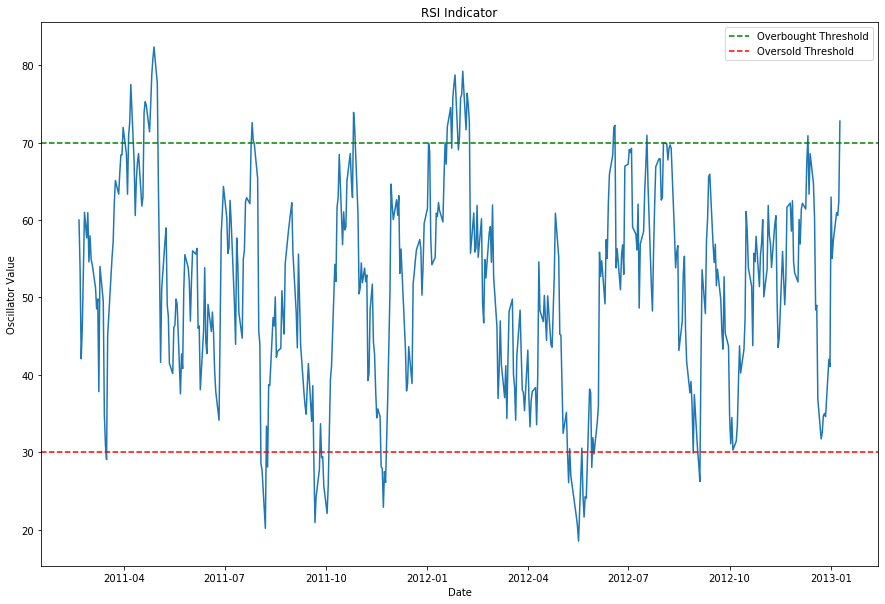

In [685]:
#plot RSI indicator to demonstrate how indicator may be used
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(technical_data.RSI10[:500])
ax.axhline(70, linestyle="--", color="green", label="Overbought Threshold")
ax.axhline(30, linestyle="--", color="red", label="Oversold Threshold")
ax.set_ylabel("Oscillator Value")
ax.set_xlabel("Date")
ax.set_title("RSI Indicator")
plt.legend()

In [686]:
technical_data.isna().sum().sum()

21

In [687]:
technical_data = technical_data.fillna(method='bfill')

## 7.3 Feature Generation - Sentiment Analysis

Here, Sentiment Analysis feature are generated as shown earlier but for entire dataset with a number of new features extracted to capture further abstractions of the market.

In [688]:
#Load twitter data from earlier notebook
twitter_df = pd.read_csv("./Data/demo_sa_twitter.csv")
twitter_df['Date'] = pd.to_datetime(twitter_df.Date, format="%Y-%m-%d %H:%M:%S.%f")
twitter_df['Date'] = pd.DataFrame(twitter_df.Date).applymap(lambda x: x.date())
twitter_df = twitter_df.drop(columns=['Unnamed: 0'])
twitter_df

Date                   ID  \
0     2018-12-31  1079743531382722560   
1     2018-12-30  1079508604124721152   
2     2018-12-29  1079163064933470208   
3     2018-12-29  1079059527289442304   
4     2018-12-28  1078618254816497664   
...          ...                  ...   
4602  2011-01-04    22349059058565120   
4603  2011-01-04    22340105045807104   
4604  2011-01-04    22177143656022016   
4605  2011-01-04    22152602259034112   
4606  2011-01-03    21977700684005376   

                                                  Tweet             User  
0     The AUD/USD is driving me crazy, $USD goes dow...  petergo99037185  
1     AUSTRALIA currency policy of minus 25% to USD ...   ArthurKokontis  
2     The AUD/USD exchange rate is about to make a r...     wijaranakula  
3     AUD/USD is perilously close to the October low...      breaksnrevs  
4     AUD/USD .7064!!!  So everything bought in the ...        bodgejob2  
...                                                 ...              ...  
4602  AUD/USD is the biggest loser so far in 2011.  ...       GaryDeduke  
4603  FX Levels and Outlooks - USD/CAD AUD/USD Gold:...         boposlav  
4604  I think a sell of aud/usd pair with TP at 0.99...    ashwinksharma  
4605          Not sure the AUD/USD is readyto climb yet       Poppyjerry  
4606  My trade room is long AUD/USD from 1.0180. Ema...     NewstraderFX  

[4607 rows x 4 columns]

In [689]:
#Function to clean an inputed tweet - note this is different to headlines clean as twitter has specific characters used
def clean_twitter(text):

    # remove old style retweet text "RT"
    text = re.sub(r'^RT[\s]+', '', text)

    # remove hyperlinks
    text = re.sub(r"http\S+", '', text)

    # remove hashtags
    text = re.sub(r'#', '', text)
    
    # remove dashes
    text = re.sub(r'-', '', text)

    # remove mentions
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  

    # remove punctuations
    text = re.sub(r'['+string.punctuation+']+', ' ', text)
    
    #remove new lines
    text = re.sub(r'\n', '', text)
    
    return text

In [690]:
#Generate cleaned tweets
twitter_df['Cleaned'] = pd.DataFrame(twitter_df.Tweet).applymap(lambda x: clean_twitter(x))

twitter_df

Date                   ID  \
0     2018-12-31  1079743531382722560   
1     2018-12-30  1079508604124721152   
2     2018-12-29  1079163064933470208   
3     2018-12-29  1079059527289442304   
4     2018-12-28  1078618254816497664   
...          ...                  ...   
4602  2011-01-04    22349059058565120   
4603  2011-01-04    22340105045807104   
4604  2011-01-04    22177143656022016   
4605  2011-01-04    22152602259034112   
4606  2011-01-03    21977700684005376   

                                                  Tweet             User  \
0     The AUD/USD is driving me crazy, $USD goes dow...  petergo99037185   
1     AUSTRALIA currency policy of minus 25% to USD ...   ArthurKokontis   
2     The AUD/USD exchange rate is about to make a r...     wijaranakula   
3     AUD/USD is perilously close to the October low...      breaksnrevs   
4     AUD/USD .7064!!!  So everything bought in the ...        bodgejob2   
...                                                 ...              ...   
4602  AUD/USD is the biggest loser so far in 2011.  ...       GaryDeduke   
4603  FX Levels and Outlooks - USD/CAD AUD/USD Gold:...         boposlav   
4604  I think a sell of aud/usd pair with TP at 0.99...    ashwinksharma   
4605          Not sure the AUD/USD is readyto climb yet       Poppyjerry   
4606  My trade room is long AUD/USD from 1.0180. Ema...     NewstraderFX   

                                                Cleaned  
0     The AUD USD is driving me crazy   USD goes dow...  
1     AUSTRALIA currency policy of minus 25  to USD ...  
2     The AUD USD exchange rate is about to make a r...  
3     AUD USD is perilously close to the October low...  
4     AUD USD  7064   So everything bought in the  7...  
...                                                 ...  
4602  AUD USD is the biggest loser so far in 2011   ...  
4603  FX Levels and Outlooks  USD CAD AUD USD Gold  ...  
4604  I think a sell of aud usd pair with TP at 0 99...  
4605          Not sure the AUD USD is readyto climb yet  
4606  My trade room is long AUD USD from 1 0180  Ema...  

[4607 rows x 5 columns]

In [691]:
#Intialise sentiment analyzer model and update lexicon with financial jargon and appropriate costs
analyser = SentimentIntensityAnalyzer()

new_words = {
    'highs': 5.0,
    'lows': -5.0,
    'higher': 2.0,
    'lower': -2.0,
    'high': 5.0,
    'low': -5.0,
    'crash': -7.0,
    'crashes': -7.0,
    'bullish': 5.0,
    'bearish': -5.0,
    'bulls': 5.0,
    'bears': -5.0,
    'drop': -3.0,
    'drops': -3.0,
    'surges': 3.0,
    'surges': 3.0,
    'up': 2.0,
    'down': -2.0,
    'soars': 4.0,
    'soaring': 4.0,
    'dropping': -3,
    'strengthens': 10,
    'strength': 10,
    'rise': 12,
    'rises': 12,
    'dips': -12,
    'dip': -12,
    'weak': -8,
    'strong': 8,
    'slip': -10,
    'slips': -10
}

analyser.lexicon.update(new_words)

#method for returning decimal value for an inputted tweet based on the positivity/negativity represented in the text
def get_sentiment(tweet):
    
    score = analyser.polarity_scores(tweet)['compound']
    
    return score

In [692]:
twitter_df['Sentiment'] = pd.DataFrame(twitter_df.Cleaned).applymap(lambda x: get_sentiment(x))
twitter_df

Date                   ID  \
0     2018-12-31  1079743531382722560   
1     2018-12-30  1079508604124721152   
2     2018-12-29  1079163064933470208   
3     2018-12-29  1079059527289442304   
4     2018-12-28  1078618254816497664   
...          ...                  ...   
4602  2011-01-04    22349059058565120   
4603  2011-01-04    22340105045807104   
4604  2011-01-04    22177143656022016   
4605  2011-01-04    22152602259034112   
4606  2011-01-03    21977700684005376   

                                                  Tweet             User  \
0     The AUD/USD is driving me crazy, $USD goes dow...  petergo99037185   
1     AUSTRALIA currency policy of minus 25% to USD ...   ArthurKokontis   
2     The AUD/USD exchange rate is about to make a r...     wijaranakula   
3     AUD/USD is perilously close to the October low...      breaksnrevs   
4     AUD/USD .7064!!!  So everything bought in the ...        bodgejob2   
...                                                 ...              ...   
4602  AUD/USD is the biggest loser so far in 2011.  ...       GaryDeduke   
4603  FX Levels and Outlooks - USD/CAD AUD/USD Gold:...         boposlav   
4604  I think a sell of aud/usd pair with TP at 0.99...    ashwinksharma   
4605          Not sure the AUD/USD is readyto climb yet       Poppyjerry   
4606  My trade room is long AUD/USD from 1.0180. Ema...     NewstraderFX   

                                                Cleaned  Sentiment  
0     The AUD USD is driving me crazy   USD goes dow...    -0.8934  
1     AUSTRALIA currency policy of minus 25  to USD ...    -0.5106  
2     The AUD USD exchange rate is about to make a r...    -0.9001  
3     AUD USD is perilously close to the October low...    -0.8689  
4     AUD USD  7064   So everything bought in the  7...     0.8271  
...                                                 ...        ...  
4602  AUD USD is the biggest loser so far in 2011   ...    -0.8885  
4603  FX Levels and Outlooks  USD CAD AUD USD Gold  ...     0.0000  
4604  I think a sell of aud usd pair with TP at 0 99...     0.4404  
4605          Not sure the AUD USD is readyto climb yet    -0.2411  
4606  My trade room is long AUD USD from 1 0180  Ema...     0.1531  

[4607 rows x 6 columns]

In [693]:
#Aggregate sentiments to acheive daily sentiments
twitter_sentiment_data = twitter_df.groupby('Date', as_index=True).agg({'Sentiment': ['mean']})

twitter_sentiment_data.columns = ['Sentiment']

twitter_sentiment_data

Sentiment
Date                 
2011-01-03   0.153100
2011-01-04  -0.137840
2011-01-05  -0.458800
2011-01-06  -0.080400
2011-01-07  -0.458800
...               ...
2018-12-27  -0.685082
2018-12-28  -0.020900
2018-12-29  -0.884500
2018-12-30  -0.510600
2018-12-31  -0.893400

[1838 rows x 1 columns]

In [694]:
date_range = pd.date_range(start='20110101', end='20190101', freq='D')
missing_tweets = pd.DataFrame(index=date_range)
missing_tweets = missing_tweets.join(twitter_sentiment_data)
print("Number of missing news sentiment values:", missing_tweets.isna().sum().sum())

Number of missing news sentiment values: 1085


In [695]:
#interpolation to fill missed values and then back/forward fill
#Fill missing sentiment data with interpolation forward and fillings back/forwards
missing_tweets['Sentiment'] = missing_tweets['Sentiment'].interpolate(method='time', order=2)
missing_tweets = missing_tweets.fillna(method='bfill')
missing_tweets = missing_tweets.fillna(method='ffill')

In [696]:
twitter_sentiment = missing_tweets.copy()
twitter_sentiment

Sentiment
2011-01-01    0.15310
2011-01-02    0.15310
2011-01-03    0.15310
2011-01-04   -0.13784
2011-01-05   -0.45880
...               ...
2018-12-28   -0.02090
2018-12-29   -0.88450
2018-12-30   -0.51060
2018-12-31   -0.89340
2019-01-01   -0.89340

[2923 rows x 1 columns]

In [697]:
#Load twitter data from earlier notebook
reddit_df = pd.read_csv("./Data/demo_sa_reddit.csv")
reddit_df = reddit_df.drop(columns=['Unnamed: 0'])
reddit_df

Date                                             Titles  \
0     2011-01-03          EUR USD Has Potential for Upside Momentum   
1     2011-01-04  USD JPY is Once Again Steering Toward the 1995...   
2     2011-01-06  EUR/USD Technical Analysis | Support & Resista...   
3     2011-01-06                EUR USD Re-Testing the 1.3000 Level   
4     2011-01-07  EUR/USD Technical Analysis | Euro/Dollar | 7 J...   
...          ...                                                ...   
8481  2018-12-29                The Dollar Store Backlash Has Begun   
8482  2018-12-31                              Is Dollar a Sisyphus?   
8483  2018-12-31                              Is Dollar a Sisyphus?   
8484  2018-12-31  U.S. dollar share of global currency reserves ...   
8485  2018-12-31  2019 - The Year of the "Human Spring"... It is...   

        Content  Score  Upvote Ratio  
0           NaN      1          1.00  
1           NaN      1          1.00  
2           NaN      1          1.00  
3           NaN      1          1.00  
4           NaN      1          1.00  
...         ...    ...           ...  
8481        NaN     75          0.82  
8482  [deleted]      1          1.00  
8483  [removed]      1          1.00  
8484  [deleted]     44          0.85  
8485        NaN      0          0.42  

[8486 rows x 5 columns]

In [698]:
#Function to clean an inputed text string
def clean(text):

    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # remove hashtags
    text = re.sub(r'#', '', text)
    
    # remove dashes
    text = re.sub(r'–', '', text)

    # remove punctuations
    text = re.sub(r'['+string.punctuation+']+', ' ', text)
    
    #remove new lines
    text = re.sub(r'\n', '', text)
    
    text = text.lower()
    
    return text

In [699]:
#remove all posts who have less than 5 upvotes
reddit_df = reddit_df[reddit_df['Score'] !=0]

#remove all posts that have below 70% upvoted ratio
reddit_df = reddit_df[reddit_df['Upvote Ratio'] >= 0.7]

reddit_df['Cleaned'] = pd.DataFrame(reddit_df.Titles).applymap(lambda x: clean(x))

reddit_df['Sentiment'] = pd.DataFrame(reddit_df.Cleaned).applymap(lambda x: get_sentiment(x))

reddit_df = reddit_df.set_index(reddit_df.Date).drop(columns=['Date'])

reddit_df

Titles    Content  \
Date                                                                       
2011-01-03          EUR USD Has Potential for Upside Momentum        NaN   
2011-01-04  USD JPY is Once Again Steering Toward the 1995...        NaN   
2011-01-06  EUR/USD Technical Analysis | Support & Resista...        NaN   
2011-01-06                EUR USD Re-Testing the 1.3000 Level        NaN   
2011-01-07  EUR/USD Technical Analysis | Euro/Dollar | 7 J...        NaN   
...                                                       ...        ...   
2018-12-28           New financial crisis - the dollar crisis  [removed]   
2018-12-29                The Dollar Store Backlash Has Begun        NaN   
2018-12-31                              Is Dollar a Sisyphus?  [deleted]   
2018-12-31                              Is Dollar a Sisyphus?  [removed]   
2018-12-31  U.S. dollar share of global currency reserves ...  [deleted]   

            Score  Upvote Ratio  \
Date                              
2011-01-03      1          1.00   
2011-01-04      1          1.00   
2011-01-06      1          1.00   
2011-01-06      1          1.00   
2011-01-07      1          1.00   
...           ...           ...   
2018-12-28      1          1.00   
2018-12-29     75          0.82   
2018-12-31      1          1.00   
2018-12-31      1          1.00   
2018-12-31     44          0.85   

                                                      Cleaned  Sentiment  
Date                                                                      
2011-01-03          eur usd has potential for upside momentum     0.0000  
2011-01-04  usd jpy is once again steering toward the 1995...    -0.7906  
2011-01-06  eur usd technical analysis   support   resista...     0.4019  
2011-01-06                eur usd re testing the 1 3000 level     0.0000  
2011-01-07  eur usd technical analysis   euro dollar   7 j...     0.0000  
...                                                       ...        ...  
2018-12-28           new financial crisis   the dollar crisis    -0.8481  
2018-12-29                the dollar store backlash has begun     0.0000  
2018-12-31                              is dollar a sisyphus      0.0000  
2018-12-31                              is dollar a sisyphus      0.0000  
2018-12-31  u s  dollar share of global currency reserves ...     0.9042  

[6648 rows x 6 columns]

In [700]:
reddit_sentiment = reddit_df.groupby('Date', as_index=True).agg({'Sentiment': ['mean']})

reddit_sentiment.columns = ['Sentiment']

reddit_sentiment

Sentiment
Date                 
2011-01-02   -0.71840
2011-01-03    0.00000
2011-01-04   -0.58620
2011-01-05    0.00000
2011-01-06    0.20095
...               ...
2018-12-25    0.00000
2018-12-26   -0.62490
2018-12-28   -0.84810
2018-12-29    0.00000
2018-12-31    0.30140

[1973 rows x 1 columns]

In [701]:
date_range = pd.date_range(start='20110101', end='20190101', freq='D')
missing_reddit = pd.DataFrame(index=date_range)
missing_reddit = missing_reddit.join(reddit_sentiment)
print("Number of missing news sentiment values:", missing_reddit.isna().sum().sum())

Number of missing news sentiment values: 950


In [702]:
#interpolation to fill missed values and then back/forward fill
#Fill missing sentiment data with interpolation forward and fillings back/forwards
missing_reddit['Sentiment'] = missing_reddit['Sentiment'].interpolate(method='time', order=2)
missing_reddit = missing_reddit.fillna(method='bfill')
missing_reddit = missing_reddit.fillna(method='ffill')

In [703]:
reddit_sentiment = missing_reddit.copy()
reddit_sentiment

Sentiment
2011-01-01    -0.7184
2011-01-02    -0.7184
2011-01-03     0.0000
2011-01-04    -0.5862
2011-01-05     0.0000
...               ...
2018-12-28    -0.8481
2018-12-29     0.0000
2018-12-30     0.1507
2018-12-31     0.3014
2019-01-01     0.3014

[2923 rows x 1 columns]

## 7.4 Feature Generation - Fundamental Analysis

The final form of feature engineering is Fundamental Analysis which is performed as shown previously through the manual webscraping of financial news articles.

In [704]:
#Load twitter data from earlier notebook
news_df = pd.read_csv("./Data/demo_fa.csv")
news_df = news_df.drop(columns=['Date.1'])
news_df = news_df.dropna()
news_df

Date                                           Headline
0      2019-01-25  Forex - Pound Gains on Hopes That U.K. Might A...
1      2019-01-24   Forex - Dollar Rallies as Draghi Drags Down Euro
2      2019-01-24  Gloomy data shoves euro lower ahead of ECB mee...
3      2019-01-24  Yuan bulls re-emerge amid growing trade talk h...
4      2019-01-24  Forex - Dollar Pushes Higher But Gains Checked...
...           ...                                                ...
42070  2010-12-31         Forex - EUR/USD up during the U.S. session
42071  2010-12-31         Forex - AUD/USD up during the U.S. session
42072  2010-12-31  GLOBAL MARKETS-Stocks, commodities shine in 20...
42073  2010-12-31         Forex - NZD/USD up during the U.S. session
42074  2010-12-31  FOREX-Dollar falls but ends year higher vs majors

[42072 rows x 2 columns]

In [705]:
#Function to get headlines containing set of words
def get_articles_from_list(words, articles):
    
    news = pd.DataFrame(columns=['Date','Headline'])
    
    for word in words:
    
        found = articles[articles.Headline.str.contains(word)]
        
        news = news.append(found)
        
    news = news.set_index(news.Date)
        
    news.sort_index(inplace=True)
    
    news = news.drop_duplicates()
    
    return news

words = ['AUD/USD','USD/AUD','USA','America','Australia','US','Dollar']

news = get_articles_from_list(words, news_df)

news = news.loc['2011-01-01':'2019-01-01']

news

Date                                           Headline
Date                                                                     
2011-01-02  2011-01-02      Forex - NZD/USD down during the Asian session
2011-01-02  2011-01-02      Forex - AUD/USD down during the Asian session
2011-01-02  2011-01-02        Forex - USD/JPY up during the Asian session
2011-01-02  2011-01-02      Forex - USD/CAD down during the Asian session
2011-01-02  2011-01-02        Forex - USD/CAD weekly outlook: January 3-7
...                ...                                                ...
2018-12-26  2018-12-26  Forex - Dollar Edges Higher in Quiet Post-Chri...
2018-12-27  2018-12-27  Forex - Yen Rises Amid Renewed China-U.S. Tens...
2018-12-27  2018-12-27  Forex - Yuan Gains Despite Weak China Data; U....
2018-12-30  2018-12-30   USD Flat In Asia As US-China Trade Talks Prog...
2018-12-31  2018-12-31  Dollar ends strongest year since 2015 on defen...

[27959 rows x 2 columns]

In [706]:
date_range = pd.date_range(start='20110101', end='20190101', freq='D')
print("Number of missing days of News headlines:", len(date_range) - len(news.Date.unique()))

Number of missing days of News headlines: 531


In [707]:
news['Headline_Cleaned'] = pd.DataFrame(news.Headline).applymap(lambda x: clean(x))
news.head()

Date                                       Headline  \
Date                                                                    
2011-01-02  2011-01-02  Forex - NZD/USD down during the Asian session   
2011-01-02  2011-01-02  Forex - AUD/USD down during the Asian session   
2011-01-02  2011-01-02    Forex - USD/JPY up during the Asian session   
2011-01-02  2011-01-02  Forex - USD/CAD down during the Asian session   
2011-01-02  2011-01-02    Forex - USD/CAD weekly outlook: January 3-7   

                                         Headline_Cleaned  
Date                                                       
2011-01-02  forex   nzd usd down during the asian session  
2011-01-02  forex   aud usd down during the asian session  
2011-01-02    forex   usd jpy up during the asian session  
2011-01-02  forex   usd cad down during the asian session  
2011-01-02    forex   usd cad weekly outlook  january 3 7

In [708]:
#Generate sentiment values
news['Sentiment'] = pd.DataFrame(news.Headline_Cleaned).applymap(lambda x: get_sentiment(x))

news.head()

Date                                       Headline  \
Date                                                                    
2011-01-02  2011-01-02  Forex - NZD/USD down during the Asian session   
2011-01-02  2011-01-02  Forex - AUD/USD down during the Asian session   
2011-01-02  2011-01-02    Forex - USD/JPY up during the Asian session   
2011-01-02  2011-01-02  Forex - USD/CAD down during the Asian session   
2011-01-02  2011-01-02    Forex - USD/CAD weekly outlook: January 3-7   

                                         Headline_Cleaned  Sentiment  
Date                                                                  
2011-01-02  forex   nzd usd down during the asian session    -0.4588  
2011-01-02  forex   aud usd down during the asian session    -0.4588  
2011-01-02    forex   usd jpy up during the asian session     0.4588  
2011-01-02  forex   usd cad down during the asian session    -0.4588  
2011-01-02    forex   usd cad weekly outlook  january 3 7     0.0000

In [709]:
#Find mean sentiment for each day
sentiment = news.groupby(news.Date, as_index=True).agg({'Sentiment': ['mean']})

sentiment.columns = ['Sentiment']

sentiment

Sentiment
Date                 
2011-01-02  -0.083418
2011-01-03  -0.086181
2011-01-04  -0.038500
2011-01-05   0.119593
2011-01-06   0.021366
...               ...
2018-12-25  -0.697500
2018-12-26   0.624700
2018-12-27  -0.245900
2018-12-30   0.421500
2018-12-31   0.458800

[2392 rows x 1 columns]

In [710]:
date_range = pd.date_range(start='20110101', end='20190101', freq='D')
missing_news = pd.DataFrame(index=date_range)
missing_news = missing_news.join(sentiment)
print("Number of missing news sentiment values:", missing_news.isna().sum().sum())
#Fill missing sentiment data with interpolation forward and fillings back/forwards
missing_news['Sentiment'] = missing_news['Sentiment'].interpolate(method='time', order=2)
missing_news = missing_news.fillna(method='bfill')
missing_news = missing_news.fillna(method='ffill')

Number of missing news sentiment values: 531


In [711]:
missing_news.isna().sum()

Sentiment    0
dtype: int64

## 7.5 Generating Master DataFrame

In [712]:
masterframe = technical_data.copy()

masterframe['Reddit Sentiment'] = reddit_sentiment.shift(1)

masterframe['Twitter Sentiment'] = twitter_sentiment.shift(1)

masterframe['News Sentiment'] = missing_news.shift(1)

masterframe['Twitter Sentiment 2'] = masterframe['Twitter Sentiment'].shift(2)

masterframe['Reddit Sentiment 2'] = masterframe['Reddit Sentiment'].shift(2)

masterframe['News Sentiment 2'] = masterframe['News Sentiment'].shift(2)

masterframe['Twitter Sentiment Return'] = pd.DataFrame(masterframe['Twitter Sentiment'].pct_change()).applymap(lambda x: 0 if x in [np.inf, -np.inf] else x)

masterframe['Reddit Sentiment Return'] = pd.DataFrame(masterframe['Reddit Sentiment'].pct_change()).applymap(lambda x: 0 if x in [np.inf, -np.inf] else x)

masterframe['News Sentiment Return'] = pd.DataFrame(masterframe['News Sentiment'].pct_change()).applymap(lambda x: 0 if x in [np.inf, -np.inf] else x)

masterframe['Twitter Sentiment MA'] = masterframe['Twitter Sentiment'].rolling(5).mean()

masterframe['Reddit Sentiment MA'] = masterframe['Reddit Sentiment'].rolling(5).mean()

masterframe['News Sentiment MA'] = masterframe['News Sentiment'].rolling(5).mean()

masterframe = masterframe.fillna(method='bfill')
masterframe = masterframe.fillna(method='ffill')

masterframe

Open     High      Low    Close       Volume  Adj_Close  \
Date                                                                     
2011-02-19  1.01370  1.01432  1.01290  1.01409    2514.3501   1.006532   
2011-02-20  1.01426  1.01533  1.00749  1.00954   84486.1273   1.006837   
2011-02-21  1.00952  1.00979  0.99682  0.99899  186337.6789   1.006041   
2011-02-22  0.99898  1.00599  0.99831  1.00234  159643.3362   1.005666   
2011-02-23  1.00234  1.01240  1.00027  1.00889  173690.4416   1.005992   
...             ...      ...      ...      ...          ...        ...   
2018-12-24  0.70572  0.70706  0.70374  0.70422    3801.4900   0.716184   
2018-12-25  0.70428  0.70723  0.70333  0.70693   77848.7096   0.715259   
2018-12-26  0.70693  0.70786  0.70173  0.70352  193196.9914   0.714085   
2018-12-27  0.70338  0.70698  0.70287  0.70412  147956.1087   0.713089   
2018-12-30  0.70450  0.70721  0.70334  0.70534  108426.1493   0.712314   

              HL_Avg   High_MA    Low_MA  HL_Avg_Rolling  ...  News Sentiment  \
Date                                                      ...                   
2011-02-19  1.013610  1.014410  1.007990        1.011200  ...        0.196048   
2011-02-20  1.011410  1.015180  1.009817        1.012498  ...        0.598400   
2011-02-21  1.003305  1.013147  1.005737        1.009442  ...       -0.070585   
2011-02-22  1.002150  1.010370  1.000873        1.005622  ...       -0.181338   
2011-02-23  1.006335  1.009393  0.998467        1.003930  ...       -0.276003   
...              ...       ...       ...             ...  ...             ...   
2018-12-24  0.705400  0.708810  0.703490        0.706150  ...       -0.466744   
2018-12-25  0.705280  0.707087  0.703533        0.705310  ...       -0.729867   
2018-12-26  0.704795  0.707383  0.702933        0.705158  ...       -0.697500   
2018-12-27  0.704925  0.707357  0.702643        0.705000  ...        0.624700   
2018-12-30  0.705275  0.707350  0.702647        0.704998  ...        0.199033   

            Twitter Sentiment 2  Reddit Sentiment 2  News Sentiment 2  \
Date                                                                    
2011-02-19             0.851900              0.6369          0.196048   
2011-02-20             0.851900              0.6369          0.196048   
2011-02-21             0.851900              0.6369          0.196048   
2011-02-22             0.726833              0.4990          0.598400   
2011-02-23             0.601767              0.3611         -0.070585   
...                         ...                 ...               ...   
2018-12-24             0.475967             -0.4215         -0.409500   
2018-12-25            -0.756450             -0.2960         -0.203622   
2018-12-26            -0.700300              0.0000         -0.466744   
2018-12-27            -0.696495             -0.6249         -0.729867   
2018-12-30            -0.692691              0.0000         -0.697500   

            Twitter Sentiment Return  Reddit Sentiment Return  \
Date                                                            
2011-02-19                 -0.146809                -0.216518   
2011-02-20                 -0.146809                -0.216518   
2011-02-21                 -0.172071                -0.276353   
2011-02-22                 -0.207832                -0.381889   
2011-02-23                 -0.500000                -0.617832   
...                              ...                      ...   
2018-12-24                 -0.074228                -1.000000   
2018-12-25                 -0.005433                 0.000000   
2018-12-26                 -0.005462                -1.000000   
2018-12-27                 -0.005492                 0.000000   
2018-12-30                  0.283956                -1.000000   

            News Sentiment Return  Twitter Sentiment MA  Reddit Sentiment MA  \
Date                                                                           
2011-02-19               2.052308         

In [713]:
masterframe.isna().sum().sum()

0

## 7.5 Generating Labels

In [714]:

#get labels
def get_labels(data):

    data['Raw_Labels'] = pd.DataFrame(data.Raw_Return.shift(-1)).applymap(lambda x: 1 if x >= 0 else - 1)

    data['Smoothed_Labels'] = pd.DataFrame(data.Smoothed_Return.shift(-5)).applymap(lambda x: 1 if x >= 0 else - 1)
    
    return data

In [715]:
masterframe_labelled = get_labels(masterframe)
masterframe_labelled

Open     High      Low    Close       Volume  Adj_Close  \
Date                                                                     
2011-02-19  1.01370  1.01432  1.01290  1.01409    2514.3501   1.006532   
2011-02-20  1.01426  1.01533  1.00749  1.00954   84486.1273   1.006837   
2011-02-21  1.00952  1.00979  0.99682  0.99899  186337.6789   1.006041   
2011-02-22  0.99898  1.00599  0.99831  1.00234  159643.3362   1.005666   
2011-02-23  1.00234  1.01240  1.00027  1.00889  173690.4416   1.005992   
...             ...      ...      ...      ...          ...        ...   
2018-12-24  0.70572  0.70706  0.70374  0.70422    3801.4900   0.716184   
2018-12-25  0.70428  0.70723  0.70333  0.70693   77848.7096   0.715259   
2018-12-26  0.70693  0.70786  0.70173  0.70352  193196.9914   0.714085   
2018-12-27  0.70338  0.70698  0.70287  0.70412  147956.1087   0.713089   
2018-12-30  0.70450  0.70721  0.70334  0.70534  108426.1493   0.712314   

              HL_Avg   High_MA    Low_MA  HL_Avg_Rolling  ...  \
Date                                                      ...   
2011-02-19  1.013610  1.014410  1.007990        1.011200  ...   
2011-02-20  1.011410  1.015180  1.009817        1.012498  ...   
2011-02-21  1.003305  1.013147  1.005737        1.009442  ...   
2011-02-22  1.002150  1.010370  1.000873        1.005622  ...   
2011-02-23  1.006335  1.009393  0.998467        1.003930  ...   
...              ...       ...       ...             ...  ...   
2018-12-24  0.705400  0.708810  0.703490        0.706150  ...   
2018-12-25  0.705280  0.707087  0.703533        0.705310  ...   
2018-12-26  0.704795  0.707383  0.702933        0.705158  ...   
2018-12-27  0.704925  0.707357  0.702643        0.705000  ...   
2018-12-30  0.705275  0.707350  0.702647        0.704998  ...   

            Reddit Sentiment 2  News Sentiment 2  Twitter Sentiment Return  \
Date                                                                         
2011-02-19              0.6369          0.196048                 -0.146809   
2011-02-20              0.6369          0.196048                 -0.146809   
2011-02-21              0.6369          0.196048                 -0.172071   
2011-02-22              0.4990          0.598400                 -0.207832   
2011-02-23              0.3611         -0.070585                 -0.500000   
...                        ...               ...                       ...   
2018-12-24             -0.4215         -0.409500                 -0.074228   
2018-12-25             -0.2960         -0.203622                 -0.005433   
2018-12-26              0.0000         -0.466744                 -0.005462   
2018-12-27             -0.6249         -0.729867                 -0.005492   
2018-12-30              0.0000         -0.697500                  0.283956   

            Reddit Sentiment Return  News Sentiment Return  \
Date                                                         
2011-02-19                -0.216518               2.052308   
2011-02-20                -0.216518               2.052308   
2011-02-21                -0.276353              -1.117956   
2011-02-22                -0.381889               1.569088   
2011-02-23                -0.617832               0.522034   
...                             ...                    ...   
2018-12-24                -1.000000               1.292208   
2018-12-25                 0.000000               0.563739   
2018-12-26                -1.000000              -0.044346   
2018-12-27                 0.000000              -1.895627   
2018-12-30                -1.000000              -0.681394   

            Twitter Sentiment MA  Reddit Sentiment MA  News Sentiment MA  \
Date                                                                       
2011-02-19              0.579110             0.361100           0.053305   
2011-02-20              0.579110             0.361100           0.053305   
2011-02-21              0.579110             0.361100           0.053305   
2011

In [716]:
masterframe_labelled.isna().sum().sum()

0

## 7.6 Stationarity

In [717]:
THRESH = 0.05

#function to return all columns that are not stationary
def get_non_stationary(df, threshold):
    
    non_stationary = []
        
    for column in df.columns:
        
        check_stationary = adfuller(df[column].values)

        adf_stat = check_stationary[0]

        p_val = check_stationary[1]

        crit_vals = check_stationary[4]

        if p_val < threshold:
            
            continue
            
        else:
            
            non_stationary.append(column)
            
    return non_stationary
        
#function to make non-stationary columns stationary through integer differencing (log returns)
def make_stationary(df, cols, threshold):
    
    for col in cols:
        
        df[col] = pd.DataFrame(np.log(df[col]).pct_change()).values
    
    df = df.dropna()
    
    check = get_non_stationary(df, threshold)
    
    if len(check) == 0:
        
        print("Date is now stationary!")
        
    else:
        
        print("Data still non-stationary!")
        
    return df

In [718]:
#Make data stationary using integer differencing of log values -> log returns
masterframe_stationary = masterframe.copy()

bad_columns = get_non_stationary(masterframe_stationary, THRESH)

print("Non-stationary features:", bad_columns)

masterframe_stationary = make_stationary(masterframe_stationary, bad_columns, THRESH)

Non-stationary features: ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'HL_Avg', 'High_MA', 'Low_MA', 'HL_Avg_Rolling', 'ATR', 'BB_High', 'BB_Mid', 'BB_Low', 'DEMA10', 'DEMA15', 'SMA10', 'SMA15', 'EMA10', 'EMA15', 'SAR', 'SMA_High', 'SMA_Low', 'SSL_Down', 'SSL_Up', 'KAMA15', 'KAMA30', 'LWMA']
Date is now stationary!


In [719]:
masterframe_stationary['Raw_Labels'] = masterframe.Raw_Labels
masterframe_stationary['Smoothed_Labels'] = masterframe.Smoothed_Labels
masterframe_stationary

Open      High        Low     Close       Volume  Adj_Close  \
Date                                                                          
2011-02-20  0.040588  0.069997  -0.417820 -0.321397   84486.1273   0.046669   
2011-02-21 -0.330830 -0.359630  -1.426833 -1.106428  186337.6789  -0.116143   
2011-02-22 -1.107707 -0.386995  -0.468950 -3.312956  159643.3362  -0.061915   
2011-02-23 -3.290269  1.063543  -1.159607  2.786781  173690.4416   0.057422   
2011-02-24  2.807985  0.430864  31.637992  0.973464  125664.3700   0.195465   
...              ...       ...        ...       ...          ...        ...   
2018-12-24 -0.006148 -0.000367  -0.000849  0.007497    3801.4900   0.005586   
2018-12-25  0.005860 -0.000694   0.001659 -0.010953   77848.7096   0.003873   
2018-12-26 -0.010713 -0.002570   0.006471  0.013942  193196.9914   0.004902   
2018-12-27  0.014516  0.003600  -0.004583 -0.002424  147956.1087   0.004147   
2018-12-30 -0.004522 -0.000938  -0.001896 -0.004935  108426.1493   0.003215   

              HL_Avg   High_MA    Low_MA  HL_Avg_Rolling  ...  \
Date                                                      ...   
2011-02-20 -0.160733  0.053035  0.227506        0.115206  ...   
2011-02-21 -0.709173 -0.133078 -0.414434       -0.243421  ...   
2011-02-22 -0.349096 -0.210122 -0.847393       -0.403458  ...   
2011-02-23  1.940374 -0.093743 -2.757840       -0.300330  ...   
2011-02-24  1.095333  0.282194 -2.611983        0.846379  ...   
...              ...       ...       ...             ...  ...   
2018-12-24 -0.000609  0.010850  0.006638        0.008725  ...   
2018-12-25  0.000487  0.007073 -0.000175        0.003421  ...   
2018-12-26  0.001970 -0.001210  0.002426        0.000616  ...   
2018-12-27 -0.000527  0.000109  0.001171        0.000643  ...   
2018-12-30 -0.001420  0.000027 -0.000013        0.000007  ...   

            Reddit Sentiment 2  News Sentiment 2  Twitter Sentiment Return  \
Date                                                                         
2011-02-20              0.6369          0.196048                 -0.146809   
2011-02-21              0.6369          0.196048                 -0.172071   
2011-02-22              0.4990          0.598400                 -0.207832   
2011-02-23              0.3611         -0.070585                 -0.500000   
2011-02-24              0.2232         -0.181338                 -1.000000   
...                        ...               ...                       ...   
2018-12-24             -0.4215         -0.409500                 -0.074228   
2018-12-25             -0.2960         -0.203622                 -0.005433   
2018-12-26              0.0000         -0.466744                 -0.005462   
2018-12-27             -0.6249         -0.729867                 -0.005492   
2018-12-30              0.0000         -0.697500                  0.283956   

            Reddit Sentiment Return  News Sentiment Return  \
Date                                                         
2011-02-20                -0.216518               2.052308   
2011-02-21                -0.276353              -1.117956   
2011-02-22                -0.381889               1.569088   
2011-02-23                -0.617832               0.522034   
2011-02-24                 0.195487              -1.470598   
...                             ...                    ...   
2018-12-24                -1.000000               1.292208   
2018-12-25                 0.000000               0.563739   
2018-12-26                -1.000000              -0.044346   
2018-12-27                 0.000000              -1.895627   
2018-12-30                -1.000000              -0.681394   

            Twitter Sentiment MA  Reddit Sentiment MA  News Sentiment MA  \
Date                                                                       
2011-02-20              0.579110             0.361100           0.053305   
2011-02-21              0.579110             0.361100           0.053305   
2011-02-22      

## 7.7 Testing on RF Classifier

In [720]:
def rf_model(data, labels):
    #generate training data and split
    X = data.copy().drop(columns=['Raw_Labels','Smoothed_Labels','Raw_Return','Smoothed_Return'])
    y = labels.values.astype(int)
    
    split = int(len(X)*0.8)

    X_train = X[0:split]
    X_test = X[split+1:]
    
    y_train = y[0:split]
    y_test = y[split+1:]

    rf = RandomForestClassifier()
    rf.fit(X_train,y_train)
    predicted = rf.predict(X_test)

    score = cross_val_score(rf,X_train,y_train)
    
    print("The cross validation score for Masterframe data is", rf.score(X_test,y_test))
    
    initial = 1000
    for i in range(0,len(y_test)):
        initial = initial + data.Close[split+i+1] * predicted[i]
    print("Total Equity if trading from daily predictions on test data (initial equity = 1000):", initial)
    
    #Plot confusion matrices
    titles_options = [("Confusion matrix, without normalization", None)]

    disp = plot_confusion_matrix(rf, X_test, y_test,                           
                                 display_labels=[-1,1],
                                 cmap=plt.cm.Blues)

    disp.ax_.set_title("Confusion Matrix")
    
    return score

The cross validation score for Masterframe data is 0.5195121951219512
Total Equity if trading from daily predictions on test data (initial equity = 1000): 987.2058400000002


array([0.52887538, 0.50151976, 0.54268293, 0.38109756, 0.4695122 ])

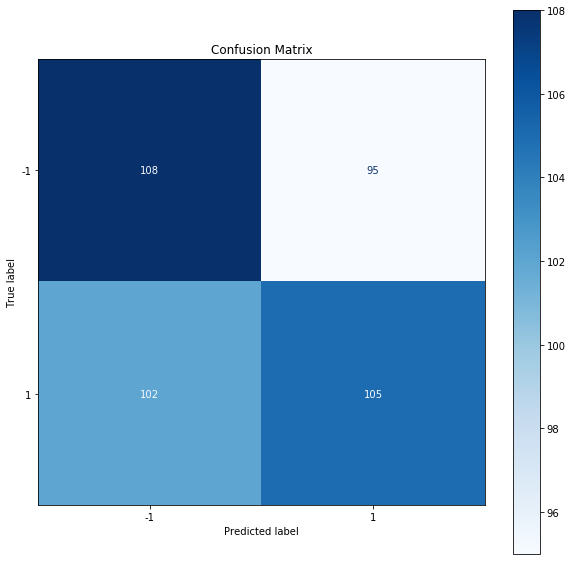

In [721]:
rf_model(masterframe_labelled, masterframe_labelled.Raw_Labels)

The cross validation score for Masterframe data is 0.6317073170731707
Total Equity if trading from daily predictions on test data (initial equity = 1000): 970.7182399999989


array([0.60790274, 0.62613982, 0.63719512, 0.62195122, 0.59146341])

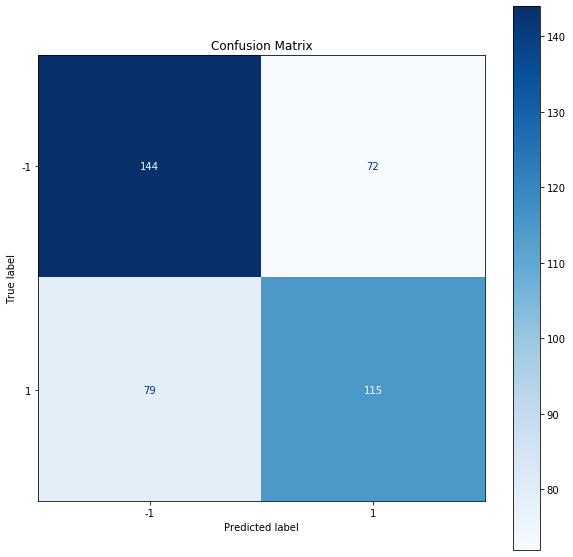

In [722]:
rf_model(masterframe_labelled, masterframe_labelled.Smoothed_Labels)

It can be observed that predicted smoothed trends clearly achieves higher classification accuracies however the performance when trading on the predictions made on test data prove to be worse than predicting next day trends. Moreover, thorough evaluation of both classification and financial metrics must be performed.

In [723]:
masterframe_labelled.to_csv("./Data/Masterframe.csv")